#### This note book provides a solution to dedup news articles that talk about the same event.
#### Highlights:

1. Apply tf-idf on Named Entities extracted from news contents - I'll show how I compute tf-idf from scratch.
2. Use graph to model similarity matrix and combine a title-based similarity model and the aforementioned content model together.

This is an unsupervised task, so I don't have accuracy measure to optimize the model. But spotchecks now and then are satisfying. In addition, I use this script to dedup news feeds for my team (of course with some web sracping and interaction with DB which I eliminated here) and get no complaints so far.

In [51]:
import os 
import pickle
from datetime import datetime
from datetime import timedelta
import pyodbc
import codecs
import re

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

# Find clusters
import networkx as nx
#import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings                     # ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Load En language model
nlp = spacy.load('en')

#### 1. Load Data

In [21]:
data = pickle.load(open("data.pkl","rb"))
data[:3]

,NewsTrackerID,ArticleTitle,CreatedDate,Content,UpdatedDate,ContentUpdateTypeID,RN
0,343,SEC investigating Yahoo over breach,2017-01-23,The Securities and Exchange Commission (SEC) o...,2017-01-23,1,1
1,344,SEC probing Yahoo over previously disclosed cy...,2017-01-23,The U.S. Securities and Exchange Commission is...,2017-01-23,1,1
2,345,Report: SEC probing Yahoo's breach disclosure ...,2017-01-23,The SEC is investigating whether Yahoo should ...,2017-01-23,1,1


#### 2. Minor clean up, count entities per article (keep only entity_count >0)

In [24]:
def clean_up(input_text):
    
    output_text = str(input_text)
    
    # Remove <br> tag, \ax0
    pattern = re.compile("<br />|\xa0|[()\"]|'s|'S")
    
    output_text = re.sub(pattern," ",output_text)

    return(output_text)
    

def num_ent(doc):           
    # Count major entities to filter out articles that are too short
    processed_doc = nlp(doc)
    counter = 0
    
    for ent in processed_doc.ents:
        if ent.label_ in ['ORG','PERSON','EVENT','GPE']:   # GPE used for counting
            counter += 1
            #print(ent.text, ent.label_)
                
    return(counter)

In [23]:
# Need to explicitly change the data type to string
# or the parser does not seem to work properly
data['Content'].astype(str)
data['Content'] = data['Content'].map(clean_up)
data['Entity_Count'] = data['Content'][mask_today].map(num_ent)

mask_suceeded = data['Entity_Count'] > 0

today_suceeded = data[mask_suceeded]

today_suceeded.shape

(255, 8)

#### 3. Dedup
##### 3.1 A pure title-similarity-based appoach
Use TfidfVectorizer from scikit-learn

In [27]:
data['ArticleTitle'].astype(str)

tfidf_vec = TfidfVectorizer(stop_words='english',
                            lowercase=True, 
                            analyzer='word', 
                            ngram_range=(1,1))
title_TFIDF = tfidf_vec.fit_transform(today_suceeded['ArticleTitle'])

print(title_TFIDF.shape)

(255, 925)


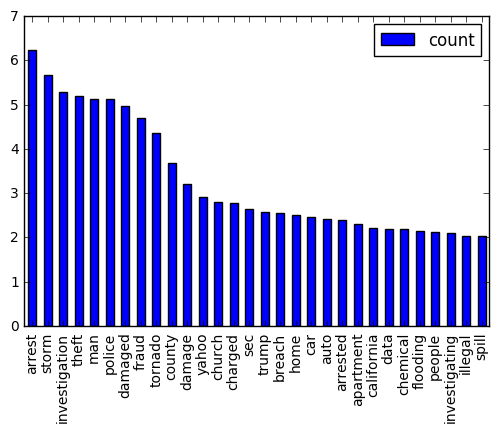

In [52]:
# See most frequent words
vocab = tfidf_vec.get_feature_names()   # Remove numbers?
freq = np.sum(title_TFIDF,axis=0).T

freq_df = pd.DataFrame(freq, index=vocab,columns = ["count"])
freq_df.sort_values(by="count",ascending=False)[:30].plot(kind="bar")

In [53]:
title_tfidf_array_n = title_TFIDF.toarray()

##### 3.2 A content-based approach
The idea is to use tf-idf on named entities. Normally, we represent each document with a bag of words and apply a tf-idf on word counts; Here, I'm representing each document with a bag of extracted entities, EG.

    Doc1: ['SEC', 'YAHOO', 'SEC', 'YAHOO', 'THE FEDERAL BUREAU OF INVESTIGATION']

Therefore, I'm going to code up my own tf-idf from scratch!

###### 3.2.1 NER on content to get ORG, PERSON, EVENT for modeling

In [97]:
def create_ent_set(doc):
    processed_doc = nlp(doc)
    doc_ent_dict = {}
    
    for ent in processed_doc.ents:
        if ent.label_ in ['ORG','PERSON','EVENT']:       # GPE not used for modeling
            if ent.text.upper() in doc_ent_dict.keys():  # All to upper case
                doc_ent_dict[ent.text.upper()] += 1
            else:
                doc_ent_dict[ent.text.upper()] = 1
                
    return(doc_ent_dict)

In [54]:
today_suceeded['Entity_List'] = today_suceeded['Content'].map(create_ent_set)
today_suceeded['Entity_List'][:5]

0    {'SENATE': 1, 'YAHOO': 5, 'FBI': 1, 'SEC': 2, ...
1    {'VERIZON COMMUNICATIONS': 1, 'YAHOO': 9, 'THE...
2    {'REUTERS': 1, 'SEC': 6, 'NEWMAN': 2, 'CRAIG N...
3    {'THE FEDERAL BUREAU OF INVESTIGATION': 1, 'SE...
4    {'VERIZON': 2, 'THE U.S. FEDERAL TRADE COMMISS...
Name: Entity_List, dtype: object

In [56]:
# Get all entities
ALL_ENT = list(set([x for record in today_suceeded['Entity_List'] for x in record.keys()]))
print("Total entities: ",len(ALL_ENT))
ALL_ENT[:5]

Total entities:  2405


['JOHN CRANE', 'RAY JOHNSON', 'DPS', 'MICHAEL MCMAHON', 'AFRIYIE']

###### 3.2.2 Compute my own TFIDF and normalize it
BINARY version is implemented here for it gives more robust results;

In [62]:
# Compute a term frequency matrix - binary version
ent_freq_count = np.empty([today_suceeded.shape[0],len(ALL_ENT)]) 

for i in range(ent_freq_count.shape[0]):
    for j in range(ent_freq_count.shape[1]):

        if ALL_ENT[j] in today_suceeded['Entity_List'].iloc[i].keys():
            ent_freq_count[i,j] = 1    
        else:
            ent_freq_count[i,j] = 0 
            
print(ent_freq_count.shape)

(255, 2405)


In [58]:
# Compute inverse document frequency from frequency matrix
idf = np.sum(ent_freq_count,axis=0)
print(idf.shape)

(2405,)


In [63]:
# Compute TFIDF
ent_tfidf_array = np.empty(ent_freq_count.shape)

for j in range(ent_freq_count.shape[1]):
    ent_tfidf_array[:,j] = np.divide(ent_freq_count[:,j],idf[j])

print(ent_tfidf_array.sum())  # QC - This should sum up to total word count
print(ent_tfidf_array.shape)

2405.0
(255, 2405)


In [64]:
# Normalize for tfidf doc length
# Use SQRT of SUM_OF_SQUARE to make sure the dot product later is cosine sim
doc_length = np.sqrt(np.sum(ent_tfidf_array**2,axis=1)) # Row-wise sum of square
ent_tfidf_array_n = np.empty(ent_freq_count.shape)

for i in range(ent_freq_count.shape[0]):
    if doc_length[i] != 0:
        ent_tfidf_array_n[i,:] = np.divide(ent_tfidf_array[i,:],doc_length[i])
    else:
        # If number of entities extracted from contents == 0, divide by a huge number
        ent_tfidf_array_n[i,:] = np.divide(ent_tfidf_array[i,:],1000000)

###### 3.2.3 Compute a cosine similarity matrix from TFIDF matrix
Since I normalized doc length to 1 in the code block above, dot product between two docs (i.e. two rows of the normalized tfidf matrix) will be cosine similarity.

In the next step, I'm going to model similarity matrix as a graph, so I'm going to extract doc pairs with high similarity score in the similarity matrix.

In [66]:
def get_sim_pairs_from_tfidf_mat(tfidf_mat,threshold):  
    """
    tfidf_mat is a normalized tf-idf matrix
    threshold is for cosine similarity score
    """
    # calucate similarity matrix from nomalized tfidf matrix
    tfidf_mat_t = np.transpose(tfidf_mat)     
    cosine_sim = np.dot(tfidf_mat, tfidf_mat_t)
    
    ## QC
    # print(cosine_sim[58,59] == cosine_sim[59,58])       # QC for symetric
    # print(cosine_sim[100,100])                          # QC for diagonal - should be 1
    
    
    # values on diagonal should all be 1
    np.fill_diagonal(cosine_sim,0)
    
    ## Choose threshold
    # print(cosine_sim.max())
    # print(cosine_sim.mean())
    THRESHOLD_SIM = np.maximum(np.percentile(cosine_sim,99),threshold)
    
    out = np.where(cosine_sim > THRESHOLD_SIM)   
    
    # get similar pairs
    pairs = []
    for i in range(len(out[0])):
        pairs.append((out[0][i],out[1][i]))
    
    return(pairs)
    

In [67]:
pairs_title = get_sim_pairs_from_tfidf_mat(title_tfidf_array_n,0.4)
pairs_content_ent = get_sim_pairs_from_tfidf_mat(ent_tfidf_array_n, 0.1)
#print(len(pairs_title))
#print(len(pairs_content_ent))

0.4 for title and 0.1 for content are arbitrary cut-off. This is an unsupervised task so I don't have any straight-forward accuracy measure that I can optimize against. 

I decide these numbers are good because:
1. When I eye-balling the result article groups, they are considerably accurate. (1~2 misses per ~250 news) which can be considered as a very decent "precision".
2. The de-duped news are served on our internal news feed, and I don't get any complaint about too much dup in the systems yet, which means "recall" is ok.

###### 3.2.4 Merge pairs with common elements - a graph-based solution!!!!
So far, I created two sets of similar article pairs - one will pick up news articles that have similar titles, the other similar contents. By modeling them with a graph, I will be able to merge the result from two totally different models together. Consider an example below:

News1: 

    [Title] Yahoo Under Scrutiny for Its Massive Cyber Breach 
    [Content] (Refers to "Yahoo" all the time.)
    
News2: 

    [Title] Yahoo Faces SEC Probe Over Data Breach 
    [Content] (Refers to "Yahoo" all the time.)
    
News3: 

    [Title] SEC Probing Yahoo over Previously Disclosed Data Breach
    [Content] (Refers to "the company" all the time.)

Intuitively, the title-based approach will put 2 and 3 together but fail to pick up 1, while the content-based approach will likely pick up 1 and 2 but fail to pick out 3. By drawing simialr pairs from both models and finding connected parts, I will pick up all three articles. Isn't that **AWESOME**?!

In addition to taking the union of two models, you can also take the intersection to stay on the conservative side. Isn't the flexibility **EVEN MORE AWESOME**?!?!



In [87]:
G = nx.Graph()

# Add edges - defined by value pairs
G.add_edges_from(pairs_title)
G.add_edges_from(pairs_content_ent)

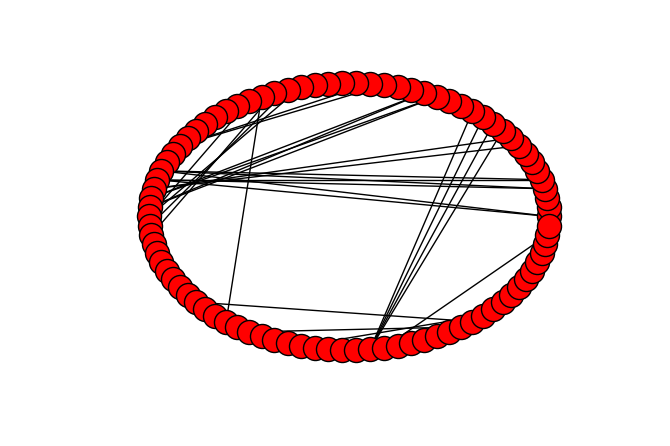

In [88]:
# Draw the graph - not informative at all, just for fun LOL
nx.draw_circular(G)

In [68]:
sim_doc_clusters = {}
for item in nx.connected_components(G):

    item_list = list(item)
    NewsTrackerID_index = today_suceeded.columns.get_loc("NewsTrackerID")  # Row index to NewsTrackerID

    if len(item_list)>1 :
        key = today_suceeded.iloc[item_list[0], NewsTrackerID_index]       
        value = [today_suceeded.iloc[index, NewsTrackerID_index] for index in item_list[1:]]

        sim_doc_clusters[key] = value

In [91]:
sim_doc_clusters

{343: [344, 345, 346, 347, 348, 458, 459],
 352: [353],
 360: [461, 359],
 372: [373],
 377: [378],
 383: [382, 448],
 389: [390],
 397: [398],
 412: [470],
 413: [473],
 430: [431],
 432: [433],
 435: [436],
 453: [454],
 463: [464, 375, 376],
 469: [399, 417],
 479: [480],
 487: [488, 489, 490, 491],
 493: [494, 510],
 496: [497, 416],
 503: [504],
 520: [566],
 522: [523],
 526: [527],
 528: [363, 364, 365, 366],
 534: [535],
 539: [540],
 554: [555, 499],
 560: [492],
 572: [571],
 575: [576],
 596: [595],
 599: [600],
 606: [533],
 609: [579]}

#### 4. Write output for evaluation

In [95]:
# Write output
similar_news_dict = {}

t0 = datetime.now()
for seed_newsid in sim_doc_clusters.keys():

    content_index = today_suceeded.columns.get_loc('ArticleTitle') # Change to "Content"
    value = [today_suceeded[today_suceeded['NewsTrackerID'] == seed_newsid].iloc[0,content_index]]
    
    for newsid in sim_doc_clusters[seed_newsid]:
        content_text = today_suceeded[today_suceeded['NewsTrackerID'] == newsid].iloc[0,content_index]
        value.append(content_text)        

    similar_news_dict[seed_newsid] = value
    

print(datetime.now() - t0)

0:00:00.062502


In [96]:
with codecs.open("output_title.txt","w","utf-8") as f:
    for key in similar_news_dict.keys():
        outputline = "❤".join(similar_news_dict[key])
        f.write(outputline+"\n")